# Evaluation

The `Evaluation` class is the actual interface for the user with the
functionalities of the `pyEvalData` package. It provides access to the raw
data via the `Source` object, given on initialization.  
The main features of the `Evaluation` class are the definition of counter
aliases as well as new counters by simple algebraic expressions.
At the same time pre- and post-filters can be applied to the raw and
evaluated data, respectively.
Much efforts have been put into the binning, averaging, and error calculation
of the raw data.
In addition to the evaluation of a list of scans or scan sequence of one or
multiple scans in dependence of an external paramter, the `Evaluation` class
also provides high-level helper functions for plotting and fitting the
according results.

## Setup

Here we do the necessary import for this example

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import pyEvalData as ped
# import lmfit for fitting
import lmfit as lf
# import some usefull fit functions
import ultrafastFitFunctions as ufff
# define the path for the example data
example_data_path = '../../../example_data/'

## Source

Here we iitialize the `Source` for the current evaluation. It is based on raw
data in a [SPEC file](https://certif.com/content/spec) which was generated by
the open-source software [Sardana](https://sardana-controls.org).

In [2]:
spec = ped.io.Spec(file_name='sardana_spec.spec',
                   file_path=example_data_path,
                   use_nexus=True,
                   force_overwrite=False,
                   update_before_read=False,
                   read_and_forget=True)

pyEvalData.io.source - INFO: Update source
pyEvalData.io.source - INFO: parse_nexus


## The `Evaluation` class

For the most basic example we just have to provide a `Source` on initialization: 

In [3]:
ev = ped.Evaluation(spec)

Now it is possible to check the available attributes of the `Evaluation`
object, which will be explained step-by-step in the upcominng sections.

In [4]:
print(ev.__doc__)

Evaluation

    Main class for evaluating data.
    The raw data is accessed via a ``Source`` object.
    The evaluation allows to bin data, calculate errors and propagate them.
    There is also an interface to ``lmfit`` for easy batch-fitting.

    Args:
        source (Source): raw data source.

    Attributes:
        log (logging.logger): logger instance from logging.
        clist (list[str]): list of counter names to evaluate.
        cdef (dict{str:str}): dict of predefined counter names and
            definitions.
        xcol (str): counter or motor for x-axis.
        t0 (float): approx. time zero for delay scans to determine the
            unpumped region of the data for normalization.
        custom_counters (list[str]): list of custom counters - default is []
        math_keys (list[str]): list of keywords which are evaluated as numpy
            functions.
        ignore_keys (list[str]): list of keywords which should not be
            evaluated.
        statistic_typ

Most of the attributes of the `Evaluation` class are well explained in the `docstring` above
and described in more details below.  
The `custom_counters` might be soon depricated.  
The `t0` attribute is used for easy normalization to 1 by
dividing the data by the mean of all values which are `xcol < t0`.
This is typically useful for time-resolved delay scans but might be renamed
for a more general approach in the future.  
The `statistics_type` attribute allows to switch between *gaussian* statistics,
which calculates the error from the standard derivation, and *poisson* statistics,
whichs calculates the error from $1/\sqrt N$ with $N$ being the total number of
photons in the according bin.

## Simple plot example

To plot data, the `Evlauation` objects does only need to know the `xcol` as
horizontal axis as well a list of *counters* to plot, which is called `clist`.

First we can check the available scan numbers in the source:

In [5]:
spec.get_all_scan_numbers()

[1, 2, 3, 4, 5, 6]

Now we can check for the available data for a specific scan

In [6]:
spec.scan1.data.dtype.names

('Diff',
 'DiffM',
 'Pt_No',
 'Pumped',
 'PumpedErr',
 'PumpedErrM',
 'PumpedM',
 'Rel',
 'RelM',
 'Unpumped',
 'UnpumpedErr',
 'UnpumpedErrM',
 'UnpumpedM',
 'chirp',
 'delay',
 'dt',
 'duration',
 'durationM',
 'envHumid',
 'envTemp',
 'freqTriggers',
 'magneticfield',
 'numTriggers',
 'numTriggersM',
 'thorlabsPM',
 'thorlabsPPM',
 'thorlabsPPMonitor')

So let's try to plot the counters `Pumped` and `Unpumped` vs the motor `delay` for scan #1: 

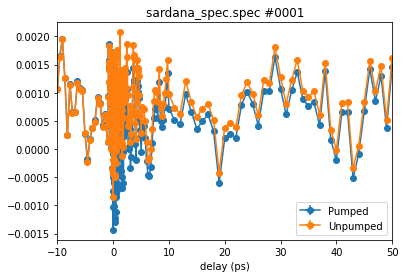

In [7]:
ev.xcol = 'delay'
ev.clist = ['Pumped', 'Unpumped']

plt.figure()
ev.plot_scans([1])
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.show()

## Algebraic expressions

For now, we only see a lot of noise. So let's work a bit further on the data we
plot. The experiment was an ultrafast [MOKE](https://en.wikipedia.org/wiki/Magneto-optic_Kerr_effect)
measurement, which followed the polarization rotation of the probe pulse after
a certain `delay` in respect to the pump pulse. Typically, this magnetic contrast
is improved by subtracting the measured signal for two opposite magnetization
directions of the sample, as the MOKE effect depends on the sample's magnetization.

In our example, we have two additional *counters* available, which contain the
data for negative magnetic fields (*M* - minus): `PumpedM` and `UnpumpedM`  
While the two former *counters* were acquired for positive fields.

Let's plot the difference signal for the *pumped* and *unpumped* signals:

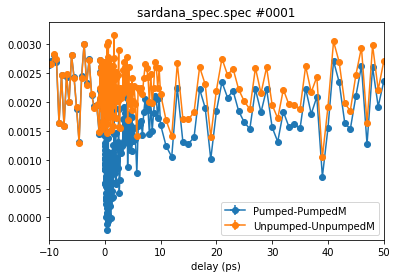

In [8]:
ev.xcol = 'delay'
ev.clist = ['Pumped-PumpedM', 'Unpumped-UnpumpedM']

plt.figure()
ev.plot_scans([1])
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.show()

The new plot shows already much more dynamisc in the *pumped* vs. the *unpumped*
signal. However, we can still improve that, by normalizing one by the other:

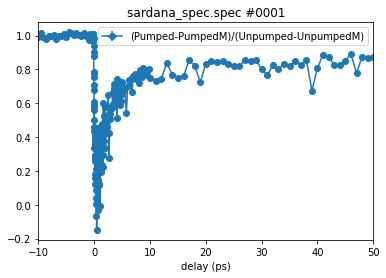

In [9]:
ev.xcol = 'delay'
ev.clist = ['(Pumped-PumpedM)/(Unpumped-UnpumpedM)']

plt.figure()
ev.plot_scans([1])
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.show()

This does look much better but we lost the absolute value of the contrast.
Let's simply multiply the trace with the average of the *unpumped* magnetic
contrast:

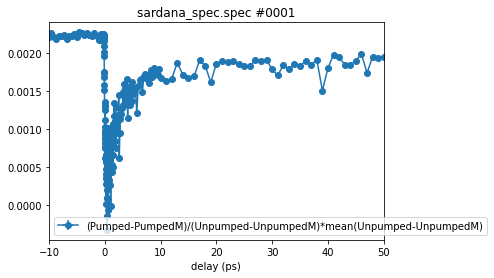

In [10]:
ev.xcol = 'delay'
ev.clist = ['(Pumped-PumpedM)/(Unpumped-UnpumpedM)*mean(Unpumped-UnpumpedM)']

plt.figure()
ev.plot_scans([1])
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.show()

So besides simple operations such as `+. -. *, /` we can also use some basic
`numpy` functionalities. You can check the available functions by inspection
of the attribute `math_keys`:

In [11]:
ev.math_keys

['mean',
 'sum',
 'diff',
 'max',
 'min',
 'round',
 'abs',
 'sin',
 'cos',
 'tan',
 'arcsin',
 'arccos',
 'arctan',
 'pi',
 'exp',
 'log',
 'log10',
 'sqrt',
 'sign']

But of course our current *counter* name is rather bulky. So lets define some
aliases using the attribute `cdef`:

In [12]:
ev.cdef['pumped_mag'] = 'Pumped-PumpedM'
ev.cdef['unpumped_mag'] = 'Unpumped-UnpumpedM'
ev.cdef['rel_mag'] = 'pumped_mag/unpumped_mag'
ev.cdef['abs_mag'] = 'pumped_mag/unpumped_mag*mean(unpumped_mag)'

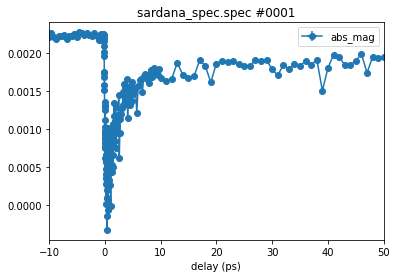

In [13]:
ev.xcol = 'delay'
ev.clist = ['abs_mag']

plt.figure()
ev.plot_scans([1])
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.show()

## Binning

In many situations it is desireable to reduce the data density or to plot the
data on a new grid. This can be easily achieved by the `xgrid` keyword of the
`plot_scans` method.

Here we plot the same data as before on a three reduced grids with 0.1, 1, and
5 ps step width. Please note that the errorbars appear due to the averaging of
multiple point in the bins of the grid. The errorbars are vertical and horizontal.
We can also skip the `xlim` setting here, as our grid is in the same range as
before.

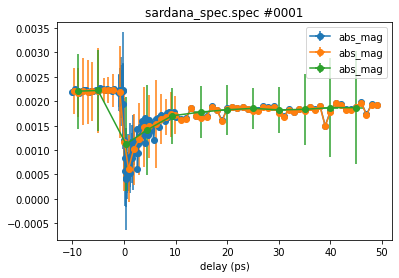

In [14]:
ev.xcol = 'delay'
ev.clist = ['abs_mag']

plt.figure()
ev.plot_scans([1], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([1], xgrid=np.r_[-10:50:1])
ev.plot_scans([1], xgrid=np.r_[-10:50:5])
plt.xlabel('delay (ps)')
plt.show()

## Averaging & error propagation

In order to improve statistics even further, scans are often repeated an averaged.
This was also done for this experimental example and all scans #1-6 were done
with the same settings.

We can simply average them by providing all scans of interest to the `plot_scans`
method:

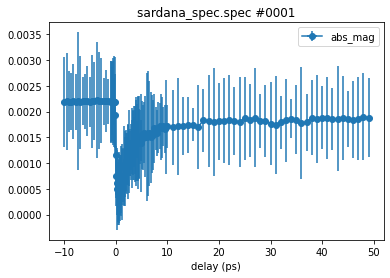

In [15]:
ev.xcol = 'delay'
ev.clist = ['abs_mag']

plt.figure()
ev.plot_scans([1, 2, 3, 4, 5, 6], xgrid=np.r_[-10:50:0.1])
plt.xlabel('delay (ps)')
plt.show()

Hm, somehow this did not really did the job, right?
Altough the scattering of the circle symbols has decreased, the errorbars
are much large as for the single scan before.

Let's check the individual scans to see what happened:

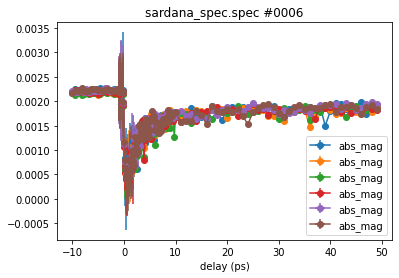

In [16]:
ev.xcol = 'delay'
ev.clist = ['abs_mag']

plt.figure()
ev.plot_scans([1], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([2], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([3], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([4], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([5], xgrid=np.r_[-10:50:0.1])
ev.plot_scans([6], xgrid=np.r_[-10:50:0.1])
plt.xlabel('delay (ps)')
plt.show()

Individually all scans look very much the same, with very small errorbars.
So why do we get so large errorbars when we average them?

Let's go one more step back and plot the `Unpumped` signal for all scans with a
large grid of 5 ps for clarity:

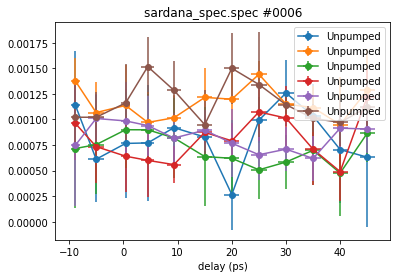

In [17]:
ev.xcol = 'delay'
ev.clist = ['Unpumped']

plt.figure()
ev.plot_scans([1], xgrid=np.r_[-10:50:5])
ev.plot_scans([2], xgrid=np.r_[-10:50:5])
ev.plot_scans([3], xgrid=np.r_[-10:50:5])
ev.plot_scans([4], xgrid=np.r_[-10:50:5])
ev.plot_scans([5], xgrid=np.r_[-10:50:5])
ev.plot_scans([6], xgrid=np.r_[-10:50:5])
plt.xlabel('delay (ps)')
plt.show()

We can observe a significant drift of the raw data which results in deviations
that are not statistically distributed anymore.

This essentially means, that it makes a difference if we  
1. evaluate the expression `abs_mag` for every scan individually and
   eventually average the resulting traces  
2. first average the raw data (`Pumped, PumpedM, Unpumped, UnpumpedM`)
   and then calculate final trace for `abs_mag` using the averaged raw data.
   In the later case we need to carry out a proper error propagation to
   determine the errors for `abs_mag`.

The `Evaluation` class allows to switch between both cases by the attribute flag
`propagate_errors` which is `True` by default and handles the error propagation
automatically using the [uncertainties](https://pythonhosted.org/uncertainties) package.
For our last example we were follwoing option 2. as described above.
Accoridngly, rather large errors from the drifiting of the raw signals were propagated.

Now lets compare to option 1. without error propagation:

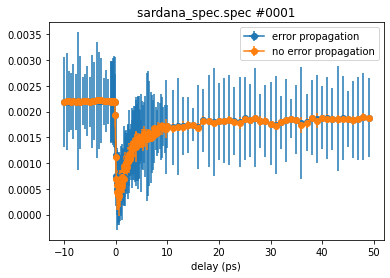

In [18]:
ev.xcol = 'delay'
ev.clist = ['abs_mag']

plt.figure()
ev.propagate_errors = True
ev.plot_scans([1, 2, 3, 4, 5, 6], xgrid=np.r_[-10:50:0.1])

ev.propagate_errors = False
ev.plot_scans([1, 2, 3, 4, 5, 6], xgrid=np.r_[-10:50:0.1])
plt.xlabel('delay (ps)')
plt.legend(['error propagation', 'no error propagation'])
plt.show()

The application of the both options strongly depends on the type of noise and 
drifts of the acquired data.

## `plot_scans()` options

Let's check all arguments of the `plot_scans()` method by simply calling:

In [19]:
help(ev.plot_scans)

Help on method plot_scans in module pyEvalData.evaluation:

plot_scans(scan_list, xgrid=array([], dtype=float64), yerr='std', xerr='std', norm2one=False, binning=True, label_text='', fmt='-o', plot_separate=False, **kwargs) method of pyEvalData.evaluation.Evaluation instance
    plot_scans
    
    Plot a list of scans from the source file.
    
    Args:
        scan_list (list[int]): list of scan numbers.
        xgrid (ndarray, optional): grid to bin the data to - default is
            empty so use the x-axis of the first scan.
        yerr (ndarray, optional): type of the errors in y: [err, std, none]
            default is 'std'.
        xerr (ndarray, optional): type of the errors in x: [err, std, none]
            default is 'std'.
        norm2one (bool, optional): normalize transient data to 1 for t < t0
            default is False.
        binning (bool, optional): enable binning of data - default is True
        label_text (str, optional): Label of the plot - default is no

Most of the above arguments are *plotting options*  and will be changed/simplified
in a future release.  
The `xerr` and `yerr` arguments allow to change the type of errorbars in `x `and `y`
direction between *standard error, standard derivation* and *no error*.  
The `norm2one` flag allows to normalize the data to 1 for all data which is before
`Evaluation.t0` on the `xcol`.  
The `skip_plot` option disables plotting at all and can be handy if only access to 
the return values is desired.  
The returned data contains the `xcol` and according error as `ndarray` named `x2plot`
and `xerr2plot`, while the according counters and errors from the `clist` are given
as `OrderedDict`s `y2plot` and `yerr2plot`. The `keys` of these dictionaries
correspond to the elements in the `clist`.

## Scan sequences

Experimentally it is common to repeat similar scans while varying an external parameter,
such as the sample environment (temperature, external fields, etc.).  
For this common task, the `Evaluation` class provides a method named
`plot_scan_sequence()` which wraps around the `plot_scans()` method.

First, we have to define the `scan_sequence` as a nested list to be correctly parsed
by the `plot_scan_sequence()` method.
For that, we use the day time of the scans as an external parameter.
We can access such meta information directly from the `Source` object as follows:

In [20]:
print(spec.scan1.time)
print(spec.scan2.time)
print(spec.scan3.time)
print(spec.scan4.time)
print(spec.scan5.time)
print(spec.scan6.time)

21:28:49
00:05:09
02:27:56
05:03:44
07:39:54
10:16:11


Now we create the `scan_sequence` as a `list`, which contains one or multiple
entries. Each entry can be a `list` or `tuple` which contains two elements:
The scan list containing one or multiple scan numbers, and a string or number
describing the external parameter.

In [21]:
scan_sequence = [
    # ([scan numbers], parameter)
    ([1], spec.scan1.time),  # first entry
    ([2], spec.scan2.time),
    ([3], spec.scan3.time),
    ([4], spec.scan4.time),
    ([5], spec.scan5.time),
    ([6], spec.scan6.time),  # last entry
]

The minimum example below does not differ too much from plotting all six scans
manually by the `plot_scans()` method:

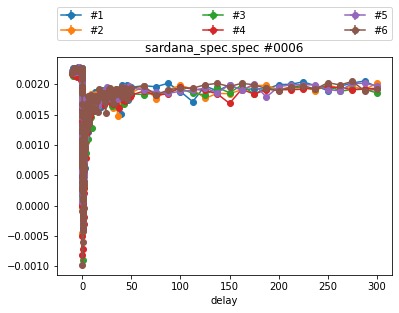

In [22]:
plt.figure()
ev.plot_scan_sequence(scan_sequence)
plt.show()

Obviously, the legend did not take the scan time into account. Let's check the
documentation for some details:

In [23]:
help(ev.plot_scan_sequence)

Help on method plot_scan_sequence in module pyEvalData.evaluation:

plot_scan_sequence(scan_sequence, xgrid=array([], dtype=float64), yerr='std', xerr='std', norm2one=False, binning=True, label_format='', fmt='-o', plot_separate=False, show_single=False, **kwargs) method of pyEvalData.evaluation.Evaluation instance
    plot_scan_sequence
    
    Plot a scan sequence from the source file.
    
    Args:
        scan_sequence (list[
            list/tuple[list[int],
            int/str]]): sequence of scan lists and parameters.
        xgrid (ndarray, optional): grid to bin the data to - default is
            empty so use the x-axis of the first scan.
        yerr (ndarray, optional): type of the errors in y: [err, std, none]
            default is 'std'.
        xerr (ndarray, optional): type of the errors in x: [err, std, none]
            default is 'std'.
        norm2one (bool, optional): normalize transient data to 1 for t < t0
            default is False.
        binning (bool,

In the docstring we can find many arguments already known from the `plot_scans()`
method. In order to fix the legend labels we need to tell the method about the
`sequence_type` as an argument. Otherwise it will enumerate the scans by default.
In our case we provided a `text` type label:

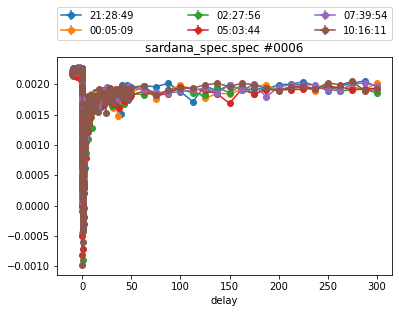

In [24]:
plt.figure()
sequence_data, parameters, names, label_texts = \
    ev.plot_scan_sequence(scan_sequence, label_format='{:s}')
plt.show()

In the example above we also catched the return values. Here the `parameters`
correspond exactly to the data we provided in the `scan_sequence` while the
`label_texts` are the formatted string as written in the legend.
The `names` correspond to the auto-generated name of each scan as given by
the `plot_scans()` method.

The actual `sequence_data` is again an `OrderedDict` where the `keys` are given
by the strings in the `xcol` and `clist` attributes of the `Evaluation` object.
Each value for a given `key` is a `list` of `ndarray`s that hold the data for
every parameter.

In [25]:
print(sequence_data.keys())

odict_keys(['abs_mag', 'abs_magErr', 'delay', 'delayErr'])


Let's make an 2D plot from the `scan_sequence`:

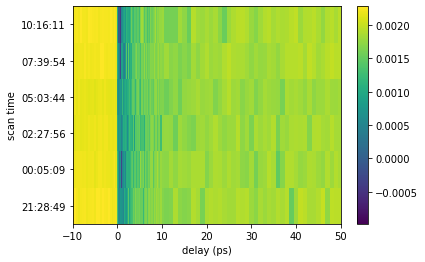

In [26]:
x = sequence_data['delay'][0]
y = np.arange(6)
z = sequence_data['abs_mag']

plt.figure()
plt.pcolormesh(x, y, z, shading='auto')
plt.xlim(-10, 50)
plt.xlabel('delay (ps)')
plt.yticks(y, label_texts, rotation='horizontal')
plt.ylabel('scan time')
plt.colorbar()
plt.show()

## Fit scan sequences

Finally, we want to fit the `scan_sequence` and extract the according fit parameters
for every trace. Here we use the `fit_scan_sequence()` method. So let's check
the documentation first:

In [27]:
help(ev.fit_scan_sequence)

Help on method fit_scan_sequence in module pyEvalData.evaluation:

fit_scan_sequence(scan_sequence, mod, pars, xgrid=[], yerr='std', xerr='std', norm2one=False, binning=True, label_format='', fmt='o', select='', fit_report=0, weights=False, fit_method='leastsq', nan_policy='propagate', last_res_as_par=False, skip_plot=False, offset_t0=False, plot_separate=False, show_single=False) method of pyEvalData.evaluation.Evaluation instance
    fit_scan_sequence
    
    Evaluate, fit, and plot the results of a given scan sequence from the
    source file.
    
    Args:
        scan_sequence (list[
            list/tuple[list[int],
            int/str]]): sequence of scan lists and parameters.
        mod (lmfit.Model): fit model.
        pars (lmfit.parameters): fit parameters.
        xgrid (ndarray, optional): grid to bin the data to - default is
            empty so use the x-axis of the first scan.
        yerr (ndarray, optional): type of the errors in y: [err, std, none]
            def

Again we find a lot of previously defined arguments which we are already familiar with.  
For the fitting, we need to provide first of all a proper fitting model `mod` and the
accroding fit parameters `pars` with *initial* and *boundray* conditions.
Here we rely on the [`lmfit`](https://lmfit.github.io/lmfit-py/) package. 
So please dive into its great documentation before continuing here.

In order to describe our data best, we would like to use a double-exponential function for
the initial decrease and subsequent increase of the magnetization. Moreover, we have to 
take into account the *step-like*  behaviour before and after the exciation at *delay=0* ps
as well as the temporal resoultion of our setup as mimiced by a convolution with a gaussian
function.

Such rather complex fitting function is provided by the
[ultrafastFitFunctions](https://github.com/EmCeBeh/ultrafastFitFunctions) package
which as been already imported in the [Setup](#setup).

In [28]:
help(ufff.doubleDecayConvScale)

Help on function doubleDecayConvScale in module ultrafastFitFunctions.dynamics:

doubleDecayConvScale(x, mu, tau1, tau2, A, q, alpha, sigS, sigH, I0)



The documentation for the fitting fucntions are hopefully comming soon :)

Now lets create the model and parameters:

In [29]:
mod = lf.Model(ufff.doubleDecayConvScale)
pars = lf.Parameters()

pars.add('mu', value=0)
pars.add('tau1', value=0.2)
pars.add('tau2', value=10)
pars.add('A', value=0.5)
pars.add('q', value=1)
pars.add('alpha', value=1, vary=False)
pars.add('sigS', value=0.05, vary=False)
pars.add('sigH', value=0, vary=False)
pars.add('I0', value=0.002)

We are not going too much in to detail of the fitting function, so let's do
the actual fit.
For that, we limit the data again on a reduced grid given by the `xgrid` argument
and provide the correct `sequence_type` for the label generation.

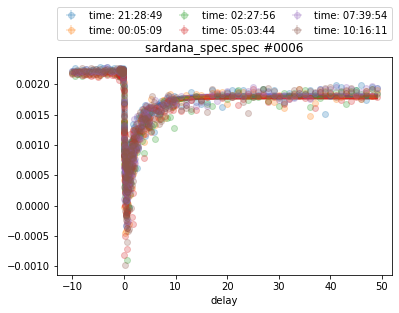

In [30]:
plt.figure()
ev.fit_scan_sequence(scan_sequence, mod, pars, xgrid=np.r_[-10:50:0.01],
                     label_format='time: {:s}')
plt.show()

The results does already look very good, but lets access some more information:

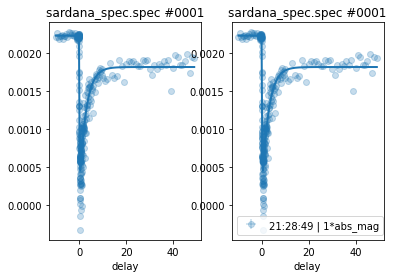

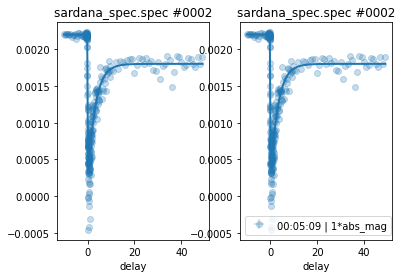

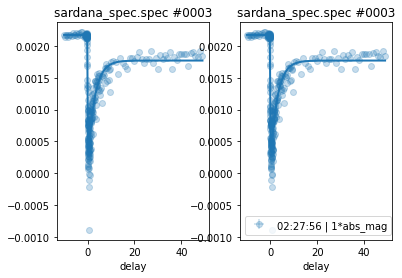

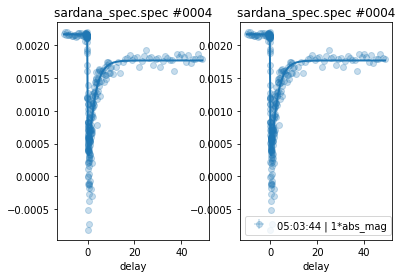

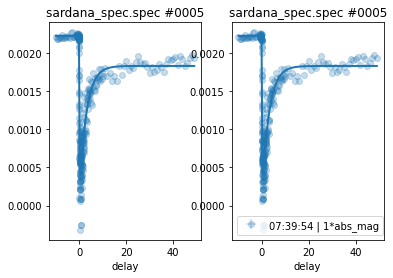

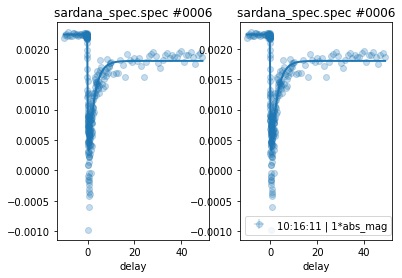

╒════════════════╤═══════════╤══════════╤═════════╤══════════╤═════════╤═════════╤════════╤════════╤════════════╕
│ counter        │        mu │     tau1 │    tau2 │        A │       q │   alpha │   sigS │   sigH │         I0 │
╞════════════════╪═══════════╪══════════╪═════════╪══════════╪═════════╪═════════╪════════╪════════╪════════════╡
│ >> 21:28:49 << │           │          │         │          │         │         │        │        │            │
├────────────────┼───────────┼──────────┼─────────┼──────────┼─────────┼─────────┼────────┼────────┼────────────┤
│ abs_mag        │ -0.112822 │ 0.143747 │ 2.76829 │ 0.185717 │ 5.14362 │       1 │   0.05 │      0 │ 0.00223483 │
├────────────────┼───────────┼──────────┼─────────┼──────────┼─────────┼─────────┼────────┼────────┼────────────┤
│ 1*abs_mag      │ -0.112822 │ 0.143747 │ 2.76829 │ 0.185717 │ 5.14362 │       1 │   0.05 │      0 │ 0.00223483 │
├────────────────┼───────────┼──────────┼─────────┼──────────┼─────────┼─────────┼──────

In [31]:
# plt.figure()

ev.clist = ['abs_mag', '1*abs_mag']
res, parameters, sequence_data = ev.fit_scan_sequence(scan_sequence, mod, pars,
                                                      xgrid=np.r_[-10:50:0.01],
                                                      label_format='{:s}',
                                                      skip_plot=False,
                                                      show_single=True,
                                                      plot_separate=True,
                                                      fit_report=1)
# plt.show()

### Access fit results

The results of the fits are given in the `res` dictionary. Here the keys correspond
again to the elements in the `clist`:

In [32]:
print(res.keys())

dict_keys(['abs_mag', '1*abs_mag'])


For every counter in the `clist` we have a nested dictionary with all best values
and errrors for the individual fit parameters. Moreover, we can access some general
parameters as the *center of mass* (`CoM`) or *integral* (`int`), as well as the
`fit` objects themselve.

In [33]:
print(res['abs_mag'].keys())

dict_keys(['mu', 'muErr', 'tau1', 'tau1Err', 'tau2', 'tau2Err', 'A', 'AErr', 'q', 'qErr', 'alpha', 'alphaErr', 'sigS', 'sigSErr', 'sigH', 'sigHErr', 'I0', 'I0Err', 'chisqr', 'redchi', 'CoM', 'int', 'fit'])


So let's plot the decay amplitude `A` for the different parameters in the
`scan_sequence`:

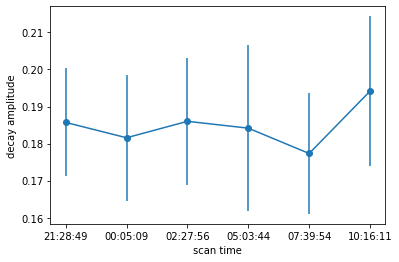

In [34]:
plt.figure()
plt.errorbar(parameters, res['abs_mag']['A'], yerr=res['abs_mag']['AErr'], fmt='-o')
plt.xlabel('scan time')
plt.ylabel('decay amplitude')
plt.show()

## Filters

In [35]:
# to be done

# new syntax

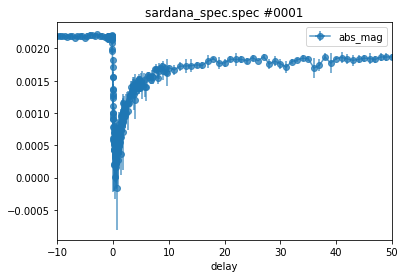

In [64]:
plt.figure()
ev.clist = ['abs_mag']
ev.scans([1,2,3,4]).plot(alpha=0.75)
plt.legend()
plt.xlim(-10, 50)
plt.show()

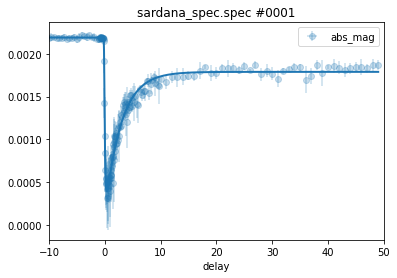

In [60]:
plt.figure()
ev.clist = ['abs_mag']
ev.scans([1,2,3,4], xgrid=np.r_[-10:50:0.05]).fit(mod, pars).plot(alpha=0.25)
plt.legend()
plt.xlim(-10, 50)
plt.show()

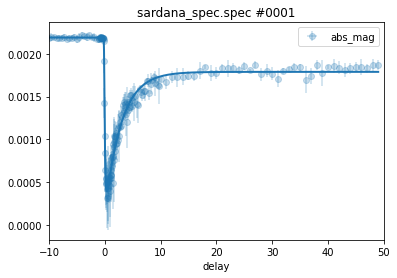

In [65]:
plt.figure()
ev.fit_scans([1,2,3,4], mod, pars, xgrid=np.r_[-10:50:0.05])
plt.legend()
plt.xlim(-10, 50)
plt.show()